Goal: create a model that predicts severity of a collision, based on the features of the collision

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import RandomizedLasso
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


1) Load data  
    - 2014 attendant, vehicle, and casualty datasets
    - Description of data: https://drive.google.com/drive/u/0/folders/1afX9SJzqmO6rQG6FDhpMlzOfoy_NwI7Q
    - Merge on AREFNO
2) Train, Test split  
3) Hyper Paramter tuning for Random Forest Classifier  
3) Feature Importance  
4) Next: Visualize a decision tree  

In [2]:
def feat_sel(X, y, model='rf', alpha=100, feat_num=20):
    '''
    performs random forest or lasso fit on specified dataframe and produces a list of 
    the top specified number of features and returns a sorted list of the features and their scores.
    '''
    #regressors = list(set(df.columns) - set([output]))

    #y = df[output]
    #X = df[regressors] #select all the columns after id and geography -- the regressors
    names = X.columns

    #rlasso = RandomizedLasso(alpha=alpha,random_state=0, normalize=True, fit_intercept=True)
    #rlasso.fit(X, y)

    rf = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=100)
    rf.fit(X, y)

    if model == 'lasso':
        feat_sort = (sorted(zip(map(lambda x: round(x, 10), rlasso.scores_), names), reverse=True))
    else: 
        feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
        print ('R-Score', rf.score(X, y))

    pl.figure(figsize=(8,6))
    pl.title("{} Feature importance".format(model))
    pl.bar(np.arange(feat_num), pd.DataFrame(feat_sort)[0][:feat_num], align='center')
    pl.xticks(np.arange(feat_num))
    pl.ylabel('Importance Score')

    print("{} Feature ranking:".format(model), pd.DataFrame(feat_sort)[:5])
    return feat_sort

** * Load Data * **

In [64]:
df_att = pd.read_csv('./data/2014-gla-data-extract-attendant.csv')
df_att.head()

AREFNO         Borough  Boro  Easting  Northing  \
0  0114CP00001  CITY OF LONDON     0   533540    181230   
1  0114CP00002  CITY OF LONDON     0   532680    181430   
2  0114CP00003  CITY OF LONDON     0   532090    181830   
3  0114CP00004  CITY OF LONDON     0   531770    180950   
4  0114CP00005  CITY OF LONDON     0   533130    180920   

                                Location Accident Severity  \
0      ST BOTOLPH STREET J/W HOUNDSDITCH          3 Slight   
1          MOORGATE J/W GREAT SWAN ALLEY          3 Slight   
2         ALDERGATE STREET J/W LONG LANE         2 Serious   
3  QUEEN VICTORIA STREET J/W PUDDLE DOCK         2 Serious   
4         FENCHURCH STREET J/W ROOD LANE          3 Slight   

   No. of Casualties in Acc.  No. of Vehicles in Acc. Accident Date  \
0                          1                        1     01-Jan-14   
1                          1                        1     08-Jan-14   
2                          1                        1     09-Jan-14   
3                          1                        2     08-Jan-14   
4                          1                        1     15-Jan-14   

     ...     Junction Detail         Junction Control Road Class 2 Road No. 2  \
0    ...        3 T/Stag Jun  4 Give Way/Uncontrolled            A       1211   
1    ...        3 T/Stag Jun  4 Give Way/Uncontrolled            C          0   
2    ...        3 T/Stag Jun               2 Auto Sig            C          0   
3    ...        3 T/Stag Jun               2 Auto Sig            C          0   
4    ...        3 T/Stag Jun  4 Give Way/Uncontrolled            C          0   

       Ped. Crossing Decoded Light Conditions (Banded) Weather Road Surface  \
0  0 No Xing Facility In 50m                    2 Dark  1 Fine   2 Road-Wet   
1  0 No Xing Facility In 50m                1 Daylight  1 Fine   1 Road-Dry   
2        5 Pedn Phase At Ats                    2 Dark  1 Fine   1 Road-Dry   
3        5 Pedn Phase At Ats                1 Daylight  1 Fine   1 Road-Dry   
4  0 No Xing Facility In 50m                1 Daylight  1 Fine   1 Road-Dry   

  Special Conditions C/W Hazard  
0             0 None     0 None  
1             0 None     0 None  
2             0 None     0 None  
3             0 None     0 None  
4             0 None     0 None  

[5 rows x 27 columns]

In [65]:
df_cas = pd.read_csv('./data/2014-gla-data-extract-casualty.csv')
df_cas.head()

AREFNO         Borough  Boro  Easting  Northing  CREFNO  \
0  0114CP00001  CITY OF LONDON     0   533540    181230       1   
1  0114CP00002  CITY OF LONDON     0   532680    181430       1   
2  0114CP00003  CITY OF LONDON     0   532090    181830       1   
3  0114CP00004  CITY OF LONDON     0   531770    180950       1   
4  0114CP00005  CITY OF LONDON     0   533130    180920       1   

   Casualty Class Casualty Sex Casualty Age (Banded)  Casualty Age  \
0    3 Pedestrian       1 Male                 25-59            29   
1    3 Pedestrian       1 Male                 25-59            48   
2    3 Pedestrian       1 Male               Unknown             0   
3  1 Driver/Rider       1 Male                 25-59            33   
4    3 Pedestrian       1 Male                 25-59            31   

   No. of Casualties Casualty Severity                   Ped. Location  \
0                  1          3 Slight  05 Crossing Road (Not On Xing)   
1                  1          3 Slight  05 Crossing Road (Not On Xing)   
2                  1         2 Serious    01 Crossing Road On Ped Xing   
3                  1         2 Serious                      -2 Unknown   
4                  1          3 Slight          06 On Footpath - Verge   

           Ped. Movement       Mode of Travel     
0     9 Unknown Or Other         1 Pedestrian     
1     9 Unknown Or Other         1 Pedestrian     
2  3 From Drivers O/Side         1 Pedestrian     
3                 -2 N/A  3 Powered 2 Wheeler     
4     9 Unknown Or Other         1 Pedestrian

In [66]:
df_veh = pd.read_csv('./data/2014-gla-data-extract-vehicle.csv')
df_veh.head()

AREFNO         Borough  Boro  Easting  Northing  Vehicle Ref.  \
0  0114CP00001  CITY OF LONDON     0   533540    181230             1   
1  0114CP00002  CITY OF LONDON     0   532680    181430             1   
2  0114CP00003  CITY OF LONDON     0   532090    181830             1   
3  0114CP00004  CITY OF LONDON     0   531770    180950             1   
4  0114CP00004  CITY OF LONDON     0   531770    180950             2   

      Vehicle Type Vehicle Type (Banded)        Vehicle Manoeuvres  \
0          08 Taxi                4 Taxi      18 Going Ahead Other   
1   21 Gds => 7.5t      7 Goods vehicles              01 Reversing   
2           09 Car                 3 Car      18 Going Ahead Other   
3           09 Car                 3 Car      18 Going Ahead Other   
4  03 M/C 50-125cc   2 Powered 2 wheeler  13 Overtake Move Veh O/S   

         Vehicle Skidding ... Junction Location Object in C/W  \
0  0 No Skidding/Overturn ...         1 Jct App       00 None   
1  0 No Skidding/Overturn ...         8 Jct Mid       00 None   
2  0 No Skidding/Overturn ...         8 Jct Mid       00 None   
3  0 No Skidding/Overturn ...         1 Jct App       00 None   
4  0 No Skidding/Overturn ...         1 Jct App       00 None   

  Veh. Leaving C/W Veh. off C/W        Veh. Impact     VJNYPURP DECODED  \
0  0 Did Not Leave      00 None  1 Front Hit First    5 Other/Not Known   
1  0 Did Not Leave      00 None   2 Back Hit First    5 Other/Not Known   
2  0 Did Not Leave      00 None  1 Front Hit First  2 Comm To/From Work   
3  0 Did Not Leave      00 None    3 O/S Hit First   1 Jny Part of Work   
4  0 Did Not Leave      00 None    4 N/S Hit First  2 Comm To/From Work   

     Driver Sex Driver Age  Driver Age (Banded)     
0        1 Male         55                35-64     
1  3 Not Traced          0              Unknown     
2        1 Male         57                35-64     
3        1 Male         45                35-64     
4        1 Male         33                25-34     

[5 rows x 21 columns]

In [67]:
print ('len df_att: ', len(df_att))
print ('len df_cas: ', len(df_cas))
len(pd.merge(df_att, df_cas, on='AREFNO', how='inner'))

len df_att:  25992
len df_cas:  30785


30785

More casualities than attendants entries -- more than one casuality per accident

Merge keeping the duplicates

In [68]:
df_crash = pd.merge(df_att, df_cas, on='AREFNO', how='inner')

print ('len df_crash: ', len(df_crash))
print ('len df_veh: ', len(df_veh))
len(pd.merge(df_crash, df_veh, on='AREFNO', how='inner'))

len df_crash:  30785
len df_veh:  46074


56406

Each accident has more than one vehicle. Merge to keep duplicates.

In [69]:
df_crash = pd.merge(df_crash, df_veh, on='AREFNO', how='inner')

In [70]:
df_crash['Casualty Class'].value_counts()

1 Driver/Rider    40640
2 Passenger        9916
3 Pedestrian       5850
Name: Casualty Class, dtype: int64

In [71]:
df_crash.columns

Index(['AREFNO', 'Borough_x', 'Boro_x', 'Easting_x', 'Northing_x', 'Location',
       'Accident Severity', 'No. of Casualties in Acc.',
       'No. of Vehicles in Acc.', 'Accident Date', 'Day', 'Time', 'Highway',
       'Road Class 1', 'Road No. 1', 'Road Type', 'Speed Limit',
       'Junction Detail', 'Junction Control', 'Road Class 2', 'Road No. 2',
       'Ped. Crossing Decoded', 'Light Conditions (Banded)', 'Weather',
       'Road Surface', 'Special Conditions', 'C/W Hazard', 'Borough_y',
       'Boro_y', 'Easting_y', 'Northing_y', 'CREFNO', 'Casualty Class',
       'Casualty Sex', 'Casualty Age (Banded)', 'Casualty Age',
       'No. of Casualties', 'Casualty Severity', 'Ped. Location',
       'Ped. Movement', 'Mode of Travel', ' _x', 'Borough', 'Boro', 'Easting',
       'Northing', 'Vehicle Ref.', 'Vehicle Type', 'Vehicle Type (Banded)',
       'Vehicle Manoeuvres', 'Vehicle Skidding', 'Restricted Lane',
       'Junction Location', 'Object in C/W', 'Veh. Leaving C/W',
       'Veh.

In [72]:
df_crash.Time = [(x.strip("'")) for x in df_crash.Time]

In [73]:
df_crash.Time = [int(x[:2]) + int(x[-2:])/60 for x in df_crash.Time]

***2) Train, Test split  ***

- repeat the samples in the smallest class --> repeat the observations from the smallest (just do it with the training set) -- to rebalance (maybe add in cross validation)
- accuracy 
    -- how much better than the naive baselines (predict all one class)
    -- print confusion matrix (to visuzliae imbalanced problems)

In [74]:
df_crash.isnull().sum().sum()

0

In [78]:
X.dtypes

Day                           object
Time                         float64
Highway                       object
Casualty Class                object
Casualty Sex                  object
Casualty Age (Banded)         object
Casualty Age                   int64
Road Class 1                  object
Road Type                     object
Speed Limit                   object
Junction Detail               object
Junction Control              object
Road Class 2                  object
Ped. Crossing Decoded         object
Light Conditions (Banded)     object
Weather                       object
Road Surface                  object
Special Conditions            object
C/W Hazard                    object
Casualty Class                object
No. of Casualties              int64
Ped. Location                 object
Ped. Movement                 object
Mode of Travel                object
Vehicle Type                  object
Vehicle Type (Banded)         object
Vehicle Manoeuvres            object
V

In [82]:
# Select X and y data

y = df_crash['Accident Severity']

X = df_crash[[
    'Day', 'Time', 'Highway',
       'Road Class 1', 'Road Type', 'Speed Limit',
       'Junction Detail', 'Junction Control', 'Road Class 2', 
       'Ped. Crossing Decoded', 'Light Conditions (Banded)', 'Weather',
       'Road Surface', 'Special Conditions', 'C/W Hazard', 
       'Ped. Location',
       'Ped. Movement', 'Mode of Travel', 'Vehicle Type',
        'Vehicle Type (Banded)',
       'Vehicle Manoeuvres', 'Vehicle Skidding', 'Restricted Lane',
       'Junction Location', 'Object in C/W', 'Veh. Leaving C/W',
       'Veh. off C/W','VJNYPURP DECODED', 'Driver Sex',
       'Driver Age', 'Driver Age (Banded)', 'Casualty Class',
       'Casualty Sex', 'Casualty Age (Banded)', 'Casualty Age']]

print ('X shape: ', X.shape)
print ('y shape: ', y.shape)

X=pd.get_dummies(X)
print ('X shape: ', X.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=0, stratify=y)

X shape:  (56406, 35)
y shape:  (56406,)
X shape:  (56406, 234)


***4) Feature Importance  ***

In [83]:
rf = RandomForestClassifier(n_jobs=-1, random_state=0,n_estimators=100)

rf=rf.fit(X_train,y_train)#run predictor with each parameter using training data
pred=rf.predict(X_test)

print ('Accuracy: %.2f' % ((len(y_test[pred == y_test])/len(y_test))*100))


Accuracy: 93.37


In [87]:
names[:5]

Index(['Time', 'Driver Age', 'Casualty Age', 'Day_Friday   ', 'Day_Monday   '], dtype='object')

Random Forest Feature ranking:          0                                                1
0   0.0933                                             Time
1   0.0717                                     Casualty Age
2   0.0613                                       Driver Age
3   0.0136                                    Day_Friday   
4   0.0131          Vehicle Manoeuvres_18 Going Ahead Other
5   0.0129                                   Road Class 1_A
6   0.0127                                    Day_Tuesday  
7   0.0126                                    Day_Thursday 
8   0.0123                        Driver Age (Banded)_35-64
9   0.0122                                    Highway_3 Bor
10  0.0120  Ped. Crossing Decoded_0 No Xing Facility In 50m
11  0.0120                                   Highway_1 TLRN
12  0.0116                      Junction Location_8 Jct Mid
13  0.0116                     Junction Detail_3 T/Stag Jun
14  0.0115                      Junction Location_1 Jct App


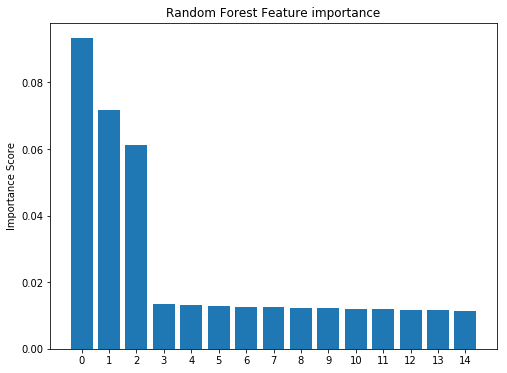

In [90]:
names = X_train.columns
feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
feat_num=50

pl.figure(figsize=(8,6))
pl.title("Random Forest Feature importance")
pl.bar(np.arange(15), pd.DataFrame(feat_sort)[0][:15], align='center')
pl.xticks(np.arange(15))
pl.ylabel('Importance Score')

print("Random Forest Feature ranking:", pd.DataFrame(feat_sort)[:15])

*** Visualizing some data ***

In [91]:
colors = dict(zip(y.unique(), ['yellow', 'orange', 'red']))

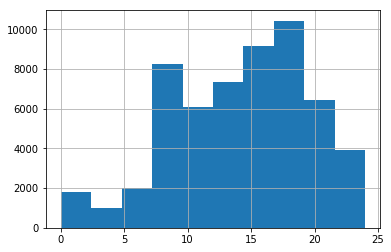

In [92]:
df_crash.Time.hist()

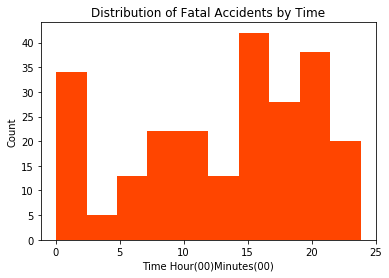

In [93]:
pl.figure()
pl.hist(df_crash[df_crash['Accident Severity'] == '1 Fatal'].Time, color='orangered')
pl.title('Distribution of Fatal Accidents by Time')
pl.xlabel('Time Hour(00)Minutes(00)')
pl.ylabel('Count')

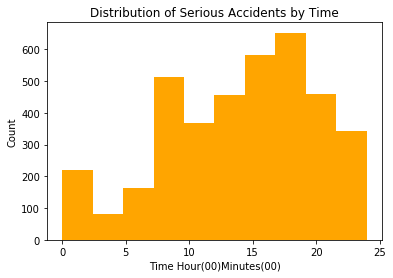

In [94]:
pl.figure()
pl.hist(df_crash[df_crash['Accident Severity'] == '2 Serious'].Time, color='orange')
pl.title('Distribution of Serious Accidents by Time')
pl.xlabel('Time Hour(00)Minutes(00)')
pl.ylabel('Count')

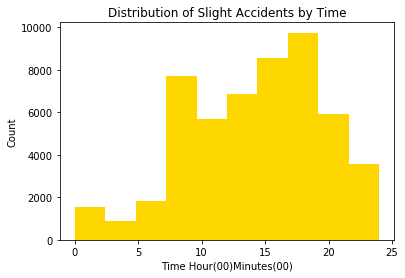

In [95]:
pl.figure()
pl.hist(df_crash[df_crash['Accident Severity'] == '3 Slight'].Time, color='gold')
pl.title('Distribution of Slight Accidents by Time')
pl.xlabel('Time Hour(00)Minutes(00)')
pl.ylabel('Count')

([array([ 1556.,   887.,  1839.,  7713.,  5681.,  6877.,  8550.,  9751.,
          5925.,  3552.]),
  array([  1776.,    968.,   2002.,   8225.,   6050.,   7333.,   9131.,
          10403.,   6385.,   3896.]),
  array([  1810.,    973.,   2015.,   8247.,   6074.,   7345.,   9172.,
          10435.,   6419.,   3916.])],
 array([  1.66666667e-02,   2.41333333e+00,   4.81000000e+00,
          7.20666667e+00,   9.60333333e+00,   1.20000000e+01,
          1.43966667e+01,   1.67933333e+01,   1.91900000e+01,
          2.15866667e+01,   2.39833333e+01]),
 <a list of 3 Lists of Patches objects>)

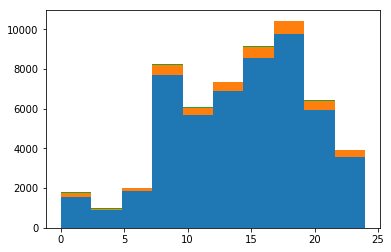

In [96]:
pl.figure()
x1 = df_crash[df_crash['Accident Severity'] == '3 Slight'].Time
x2 = df_crash[df_crash['Accident Severity'] == '2 Serious'].Time
x3 = df_crash[df_crash['Accident Severity'] == '1 Fatal'].Time
pl.hist([x1,x2,x3], stacked=True)

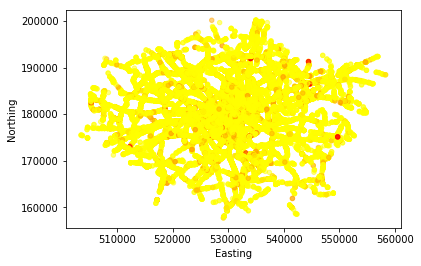

In [58]:
df_crash[df_crash['Road Class 1'] == 'A'].plot.scatter(x='Easting', y='Northing', c=y.replace(colors), alpha=.5)

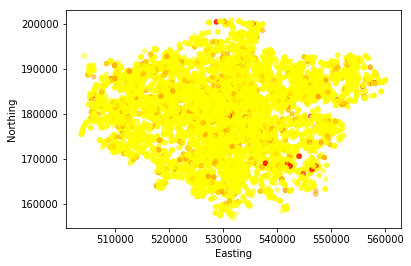

In [59]:
df_crash[df_crash['Road Class 1'] != 'A'].plot.scatter(x='Easting', y='Northing', c=y.replace(colors), alpha=.5)

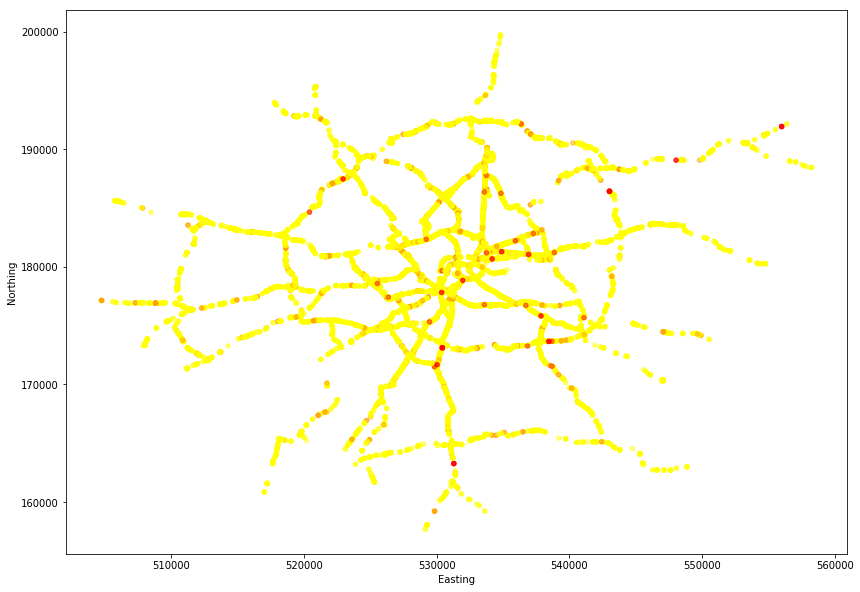

In [60]:
df_crash[df_crash['Highway'] == '1 TLRN']\
.plot.scatter(x='Easting', y='Northing', 
              c=y[df_crash['Highway'] == '1 TLRN'].replace(colors),
              figsize=(14,10), alpha=.5)

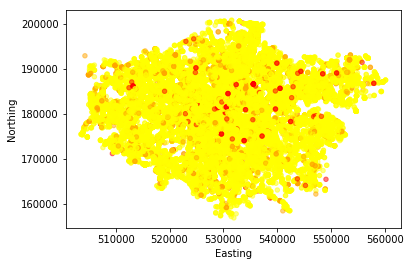

In [61]:
df_crash[df_crash['Highway'] != '1 TLRN'].plot.scatter(x='Easting', y='Northing', c=y[df_crash['Highway'] != '1 TLRN'].replace(colors), alpha=.5)

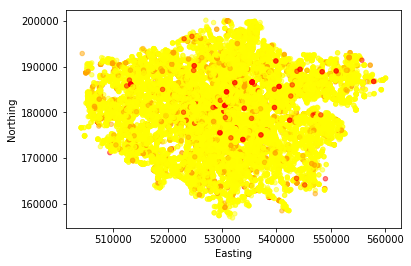

In [62]:
df_crash[df_crash['Highway'] == '3 Bor'].plot.scatter(x='Easting', y='Northing', c=y[df_crash['Highway'] == '3 Bor'].replace(colors), alpha=.5)

In [63]:
df_crash[df_crash['Day'] == 'Tuesday']#.plot.scatter(x='Easting', y='Northing', c=y.replace(colors), alpha=.5)

Empty DataFrame
Columns: [AREFNO, Borough_x, Boro_x, Easting_x, Northing_x, Location, Accident Severity, No. of Casualties in Acc., No. of Vehicles in Acc., Accident Date, Day, Time, Highway, Road Class 1, Road No. 1, Road Type, Speed Limit, Junction Detail, Junction Control, Road Class 2, Road No. 2, Ped. Crossing Decoded, Light Conditions (Banded), Weather, Road Surface, Special Conditions, C/W Hazard, Borough_y, Boro_y, Easting_y, Northing_y, CREFNO, Casualty Class, Casualty Sex, Casualty Age (Banded), Casualty Age, No. of Casualties, Casualty Severity, Ped. Location, Ped. Movement, Mode of Travel,  _x, Borough, Boro, Easting, Northing, Vehicle Ref., Vehicle Type, Vehicle Type (Banded), Vehicle Manoeuvres, Vehicle Skidding, Restricted Lane, Junction Location, Object in C/W, Veh. Leaving C/W, Veh. off C/W, Veh. Impact, VJNYPURP DECODED, Driver Sex, Driver Age, Driver Age (Banded),  _y]
Index: []

[0 rows x 62 columns]

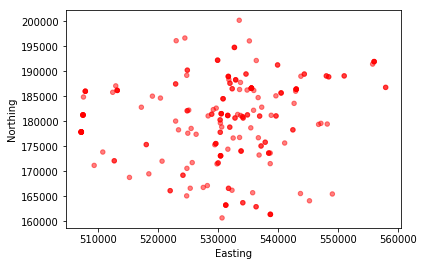

In [141]:
df_crash[df_crash['Accident Severity'] == '1 Fatal'].plot.scatter(x='Easting', y='Northing', c=y[df_crash['Accident Severity'] == '1 Fatal'].replace(colors), alpha=.5)

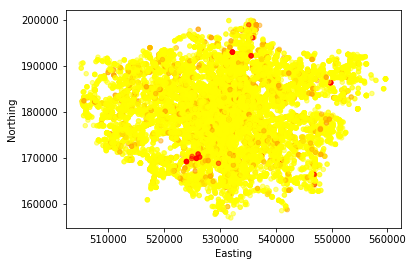

In [142]:
df_crash[df_crash['Junction Detail'] == '3 T/Stag Jun'].plot.scatter(x='Easting', y='Northing', c=y.replace(colors), alpha=.5)

*** Look at the most predictive values...drop observations that are explained by another feature? ***

In [106]:
df_tmp = df_crash

In [107]:
df_tmp.drop(['AREFNO', 'Borough_x', 'Boro_x', 'Easting_x', 'Northing_x', 'Location',
       'No. of Casualties in Acc.', 'No. of Vehicles in Acc.', 'Accident Date',
        'Borough_y', 'Boro_y', 'Easting_y', 'Northing_y', 'CREFNO',
        ' _x', 'Borough',
       'Boro', 'Easting', 'Northing', 'Vehicle Ref.',  ' _y'], axis=1, inplace=True)

In [108]:
X_log = pd.get_dummies(df_tmp)

In [109]:
df_corr = X_log.corr()

In [110]:
df_corrt = df_corr.iloc[5:8, :].T

In [111]:
df_corrt['Accident Severity_1 Fatal'].sort_values(ascending=False)

Accident Severity_1 Fatal                          1.000000
Casualty Severity_1 Fatal                          0.885493
Object in C/W_06 Hit Brdg Side                     0.064821
Object in C/W_10 Hit Kerb                          0.051524
Veh. Leaving C/W_7 Left Cwy Offside                0.050037
Veh. off C/W_02 Hit Lamp Post                      0.046208
Vehicle Type_14 Oth Mot Veh                        0.046170
Veh. Leaving C/W_4 Left Cwy Onto Central Res       0.042393
Vehicle Type (Banded)_8 Other                      0.039956
Mode of Travel_1 Pedestrian                        0.039932
Casualty Class_3 Pedestrian                        0.039932
Veh. Leaving C/W_6 Left Cwy Cross Cent/Res         0.039415
Ped. Movement_1 From Drivers N/Side                0.038647
Veh. Leaving C/W_1 Left Cwy Nearside               0.038311
Veh. off C/W_01 Hit Rd Sign/Ats                    0.038187
Veh. off C/W_10 Hit Oth Object                     0.037415
Ped. Location_04 Crossing Road Within 50

***5) Next: Visualize a decision tree  ***

In [124]:
#Select only the top 20 features to visualize in the decision tree
top_20_feat = [x for x in rf_res[1][:20]]
X_train2 = X_train[top_20_feat]
X_test2 = X_test[top_20_feat]

In [125]:
param_grid = {'max_depth':range(1,11)}
dt=DecisionTreeClassifier()
gr=GridSearchCV(dt,param_grid=param_grid)
rs=gr.fit(X_train2,y_train)
print (rs.best_params_)

#dt=DecisionTreeClassifier()
#dt.fit(X_train,y_train)

{'max_depth': 1}


In [127]:
dt = DecisionTreeClassifier(max_depth=1)
dt = dt.fit(X_train2,y_train)
print ('Accuracy: %.3f' % ((((dt.predict(X_test2) == y_test)*1).sum()/len(y_test))*100))

Accuracy: 92.687


In [130]:
from sklearn import tree

print (tree.export_graphviz(dt,out_file=None,
                         feature_names=X_train2.columns.values,  
                         class_names=['Fatal','Serious', 'Slight'],  
                         filled=True, rounded=True,  
                         special_characters=True,impurity=False).replace("<br/>",", ").replace("&le;","<=").replace("=<","=\"").replace(">,","\","))

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname=helvetica] ;
edge [fontname=helvetica] ;
0 [label="Time <= 355.5, samples = 33843, value = [139, 2286, 31418], class = Slight", fillcolor="#8139e5eb"] ;
1 [label="samples = 1515, value = [20, 181, 1314], class = Slight", fillcolor="#8139e5d9"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="samples = 32328, value = [119, 2105, 30104], class = Slight", fillcolor="#8139e5ec"] ;
0 -> 2 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
}


![Alt text](./D_tree.png)

Decision tree is pretty meaningless!